In [1]:
# Import necessary libraries/modules
import vertica_python
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
# Set up the Vertica Connection Information
username = os.getenv('VERTICA_USERNAME')
password = os.getenv('VERTICA_PASSWORD')

conn_info = {'host': 'warehouse.analytics.edx.org',
             'port': 5433,
             'user': username,
             'password': password,
             'database': 'warehouse',
             'read_timeout': 600,
             'unicode_error': 'strict',
             'ssl': False
            }

connection = vertica_python.connect(**conn_info)
cur = connection.cursor('dict')

In [3]:
# Preprocess Script to consolidate each feature piece for later aggregation
preprocess_query="""
-- Create Binary Columns for each subject within a course_id
DROP TABLE IF EXISTS tmp_course_subjects;
CREATE LOCAL TEMPORARY TABLE IF NOT EXISTS tmp_course_subjects ON COMMIT PRESERVE ROWS AS
SELECT	
	DISTINCT course_id,
	CASE 
		WHEN subject_title = 'Architecture' THEN 1
		ELSE 0
	END AS Architecture,
	CASE 
		WHEN subject_title = 'Art & Culture' THEN 1
		ELSE 0
	END AS ArtCulture,
	CASE 
		WHEN subject_title = 'Biology & Life Sciences' THEN 1
		ELSE 0
	END AS BiologyLifeSciences,
	CASE 
		WHEN subject_title = 'Business & Management' THEN 1
		ELSE 0
	END AS BusinessManagement,
	CASE 
		WHEN subject_title = 'Chemistry' THEN 1
		ELSE 0
	END AS Chemistry,
	CASE 
		WHEN subject_title = 'Communication' THEN 1
		ELSE 0
	END AS Communication,
	CASE 
		WHEN subject_title = 'Computer Science' THEN 1
		ELSE 0
	END AS ComputerScience,
	CASE 
		WHEN subject_title = 'Data Analysis & Statistics' THEN 1
		ELSE 0
	END AS DataAnalysisStatistics,
	CASE 
		WHEN subject_title = 'Design' THEN 1
		ELSE 0
	END AS Design,
	CASE 
		WHEN subject_title = 'Economics & Finance' THEN 1
		ELSE 0
	END AS EconomicsFinance,
	CASE 
		WHEN subject_title = 'Education & Teacher Training' THEN 1
		ELSE 0
	END AS EducationTeacherTraining,
	CASE 
		WHEN subject_title = 'Electronics' THEN 1
		ELSE 0
	END AS Electronics,
	CASE 
		WHEN subject_title = 'Energy & Earth Sciences' THEN 1
		ELSE 0
	END AS EnergyEarthSciences,
	CASE 
		WHEN subject_title = 'Engineering' THEN 1
		ELSE 0
	END AS Engineering,
	CASE 
		WHEN subject_title = 'Environmental Studies' THEN 1
		ELSE 0
	END AS EnvironmentalStudies,
	CASE 
		WHEN subject_title = 'Ethics' THEN 1
		ELSE 0
	END AS Ethics,
	CASE 
		WHEN subject_title = 'Food & Nutrition' THEN 1
		ELSE 0
	END AS FoodNutrition,
	CASE 
		WHEN subject_title = 'Health & Safety' THEN 1
		ELSE 0
	END AS HealthSafety,
	CASE 
		WHEN subject_title = 'History' THEN 1
		ELSE 0
	END AS History,
	CASE 
		WHEN subject_title = 'Humanities' THEN 1
		ELSE 0
	END AS Humanities,
		CASE 
		WHEN subject_title = 'Language' THEN 1
		ELSE 0
	END AS Languag,
		CASE 
		WHEN subject_title = 'Law' THEN 1
		ELSE 0
	END AS Law,
		CASE 
		WHEN subject_title = 'Literature' THEN 1
		ELSE 0
	END AS Literature,
		CASE 
		WHEN subject_title = 'Math' THEN 1
		ELSE 0
	END AS Math,
		CASE 
		WHEN subject_title = 'Medicine' THEN 1
		ELSE 0
	END AS Medicine,
		CASE 
		WHEN subject_title = 'Music' THEN 1
		ELSE 0
	END AS Music,
		CASE 
		WHEN subject_title = 'Philosophy & Ethics' THEN 1
		ELSE 0
	END AS PhilosophyEthics,
		CASE 
		WHEN subject_title = 'Physics' THEN 1
		ELSE 0
	END AS Physics,
		CASE 
		WHEN subject_title = 'Science' THEN 1
		ELSE 0
	END AS Science,
		CASE 
		WHEN subject_title = 'Social Sciences' THEN 1
		ELSE 0
	END AS SocialSciences
FROM
	production.d_course_subjects;
	
--Roll up the subjects at the course_id level
DROP TABLE IF EXISTS ed_services.course_subjects;	
CREATE TABLE IF NOT EXISTS ed_services.course_subjects AS
SELECT
	course_id,
	SUM(Architecture) AS Architecture,
	SUM(ArtCulture) AS ArtCulture,
	SUM(BiologyLifeSciences) AS BiologyLifeSciences,
	SUM(BusinessManagement) AS BusinessManagement,
	SUM(Chemistry) AS Chemistry,
	SUM(Communication) AS Communication,
	SUM(ComputerScience) AS ComputerScience,
	SUM(DataAnalysisStatistics) AS DataAnalysisStatistics,
	SUM(Design) AS Design,
	SUM(EconomicsFinance) AS EconomicsFinance,
	SUM(EducationTeacherTraining) AS EducationTeacherTraining,
	SUM(Electronics) AS Electronics,
	SUM(EnergyEarthSciences) AS EnergyEarthSciences,
	SUM(Engineering) AS Engineering,
	SUM(EnvironmentalStudies) AS EnvironmentalStudies,
	SUM(Ethics) AS Ethics,
	SUM(FoodNutrition) AS FoodNutrition,
	SUM(HealthSafety) AS HealthSafety,
	SUM(History) AS History,
	SUM(Humanities) AS Humanities,
	SUM(Languag) AS Languag,
	SUM(Law) AS Law,
	SUM(Literature) AS Literature,
	SUM(Math) AS Math,
	SUM(Medicine) AS Medicine,
	SUM(Music) AS Music,
	SUM(PhilosophyEthics) AS PhilosophyEthics,
	SUM(Physics) AS Physics,
	SUM(Science) AS Science,
	SUM(SocialSciences) AS SocialSciences,
	COUNT(*) AS cnt_subjects
FROM
	tmp_course_subjects
GROUP BY
	course_id;
    
--Create Binary columns for programs 
DROP TABLE IF EXISTS tmp_course_program;	
CREATE LOCAL TEMPORARY TABLE IF NOT EXISTS tmp_course_program ON COMMIT PRESERVE ROWS AS
SELECT
	course_id,
	CASE
		WHEN program_type = 'XSeries' THEN 1
		ELSE 0
	END AS XSeries,
	CASE
		WHEN program_type = 'Professional Certificate' THEN 1
		ELSE 0
	END AS ProfessionalCertificate,
	CASE
		WHEN program_type = 'MicroMasters' THEN 1
		ELSE 0
	END AS MicroMasters
FROM
	production.d_program_course;

--Sum up the programs columns and add column for non program courses
DROP TABLE IF EXISTS course_program;
CREATE LOCAL TEMPORARY TABLE IF NOT EXISTS course_program ON COMMIT PRESERVE ROWS AS
SELECT
	course_id,
	SUM(XSeries) AS XSeries,
	SUM(ProfessionalCertificate) AS ProfessionalCertificate,
	SUM(MicroMasters) AS MicroMasters
FROM
	tmp_course_program
GROUP BY
	course_id;  
	
--Roll up into a program summary table	
DROP TABLE IF EXISTS ed_services.course_program;
CREATE TABLE IF NOT EXISTS ed_services.course_program AS
SELECT
	a.course_id,
	ISNULL(XSeries, 0) AS XSeries,
	ISNULL(ProfessionalCertificate, 0) AS ProfessionalCertificate,
	ISNULL(MicroMasters, 0) AS MicroMasters,
	CASE
		WHEN XSeries IS NULL THEN 1
		ELSE 0
	END AS NonProgram
FROM
	business_intelligence.course_master a
LEFT JOIN
	course_program b
ON
	a.course_id = b.course_id;

--Create binary column for course track
DROP TABLE IF EXISTS tmp_course_track;	
CREATE LOCAL TEMPORARY TABLE IF NOT EXISTS tmp_course_track ON COMMIT PRESERVE ROWS AS	
SELECT
	course_id,
	CASE
		WHEN course_seat_type IN ('honor', 'audit') THEN 1
		ELSE 0
	END AS audit_track,
	CASE
		WHEN course_seat_type = 'verified' THEN 1
		ELSE 0
	END AS verified_track,
	CASE
		WHEN course_seat_type IN ('no-id-professional', 'professional') THEN 1
		ELSE 0
	END AS professional_track,
	CASE
		WHEN course_seat_type = 'credit' THEN 1
		ELSE 0
	END AS credit_track
FROM
	production.d_course_seat;
	
--Roll up of course tracks per course_id	
DROP TABLE IF EXISTS ed_services.course_track;
CREATE TABLE IF NOT EXISTS ed_services.course_track AS
SELECT
	course_id,
	SUM(audit_track) AS audit_track,
	SUM(verified_track) AS verified_track,
	SUM(professional_track) AS professional_track,
	SUM(credit_track) AS credit_track,
	COUNT(*) AS cnt_available_tracks
FROM
	tmp_course_track
GROUP BY
	course_id;
    
--Partner Rankings    
DROP TABLE IF EXISTS ed_services.partner_rankings;	
CREATE TABLE IF NOT EXISTS ed_services.partner_rankings AS
SELECT
	org_id,
	course_run_count,
	course_count,
	sum_partner_enrolls,
	sum_partner_vtr,
	sum_partner_bookings,
	ISNULL(sum_partner_enrolls/course_run_count, 0) AS enrollments_per_course_run,
	ISNULL(sum_partner_bookings/course_run_count, 0) AS bookings_per_course_run,
	ROW_NUMBER() OVER (ORDER BY sum_partner_enrolls DESC) AS enrollment_rank,
	ROW_NUMBER() OVER (ORDER BY ISNULL(sum_partner_bookings,0) DESC) AS bookings_rank,
	ROW_NUMBER() OVER (ORDER BY ISNULL(sum_partner_vtr, 0) DESC) AS vtr_rank,
	ROW_NUMBER() OVER (ORDER BY ISNULL(sum_partner_enrolls/course_run_count, 0) DESC) AS enrolls_per_course_rank,
	ROW_NUMBER() OVER (ORDER BY ISNULL(sum_partner_bookings/course_run_count, 0) DESC) AS bookings_per_course_rank
FROM
	business_intelligence.partner_stats_summary
WHERE
	org_id IS NOT NULL;
    
DROP TABLE IF EXISTS ed_services.pre_course_grouping;
CREATE TABLE IF NOT EXISTS ed_services.pre_course_grouping AS
SELECT
	course_id,
	CASE
		WHEN subject_title IN ('Architecture', 'Art & Culture', 'Design', 'Education & Teacher Training', 'Ethics', 'Food & Nutrition', 'Health & Safety', 'History', 'Humanities', 'Language', 'Law', 'Literature', 'Music', 'Philosophy & Ethics', 'Social Sciences') THEN 1
		ELSE 0
	END AS LiberalArts,
	CASE
		WHEN subject_title IN ('Biology & Life Sciences', 'Chemistry', 'Computer Science', 'Data Analysis & Statistics', 'Electronics', 'Energy & Earth Sciences', 'Engineering', 'Environmental Studies', 'Math', 'Medicine', 'Physics', 'Science') THEN 1
		ELSE 0
	END AS STEM,
	CASE
		WHEN subject_title IN ('Business & Management', 'Communication', 'Economics & Finance') THEN 1
		ELSE 0
	END AS Business
FROM
	production.d_course_subjects;
	
DROP TABLE IF EXISTS ed_services.tmp_pre_course_grouping;
CREATE TABLE IF NOT EXISTS ed_services.tmp_pre_course_grouping AS
SELECT
	course_id,
	SUM(LiberalArts) AS LiberalArts,
	SUM(STEM) AS STEM,
	SUM(Business) AS Business
FROM
	ed_services.pre_course_grouping
GROUP BY
	course_id;
	
DROP TABLE IF EXISTS ed_services.course_grouping;
CREATE TABLE IF NOT EXISTS ed_services.course_grouping AS
SELECT
	course_id,
	CASE
		WHEN LiberalArts > 0 THEN 1
		ELSE 0
	END AS LiberalArts,
	CASE
		WHEN STEM > 0 THEN 1
		ELSE 0
	END AS STEM,
	CASE
		WHEN Business > 0 THEN 1
		ELSE 0
	END AS Business
FROM
	ed_services.tmp_pre_course_grouping;
    
DROP TABLE IF EXISTS ed_services.registrations;
CREATE TABLE IF NOT EXISTS ed_services.registrations AS
SELECT
	YEAR(user_account_creation_time) AS yr,
	QUARTER(user_account_creation_time) AS qtr,
	MONTH(user_account_creation_time) AS mth,
	COUNT(*) AS registrations
FROM
	production.d_user
GROUP BY
	1,
	2,
	3;
    
DROP TABLE IF EXISTS ed_services.course_staff;
CREATE TABLE IF NOT EXISTS ed_services.course_staff AS
SELECT
	course_id,
	SUM(CASE
			WHEN role = 'instructor' THEN 1 ELSE 0
		END
		) AS instructors,
	SUM(CASE
			WHEN role = 'staff' THEN 1 ELSE 0
		END
		) AS staff
FROM
	lms_read_replica.student_courseaccessrole a
LEFT JOIN
	production.d_user b
ON
	a.user_id = b.user_id
WHERE
	role IN ('instructor', 'staff')
AND
	user_email NOT LIKE '%edx.org'
GROUP BY
	course_id;
    
DROP TABLE IF EXISTS ed_services.course_time_enrolls;
CREATE TABLE IF NOT EXISTS ed_services.course_time_enrolls AS
SELECT
	DISTINCT a.course_id,
	cum_sum_enrolls AS enrollments_at_start
FROM
	business_intelligence.course_stats_time a
LEFT JOIN
	business_intelligence.course_master b
ON
	a.course_id = b.course_id
WHERE
	date = course_start_date;    
"""

# Execute the Query from above
cur.execute(preprocess_query)

In [4]:
# Query to consolidate all data for the model to consume
# Here we only want to use courses that have ended and have above 100 enrollments
query = """
SELECT
	a.course_id,
	is_WL,
	course_start_date,
	course_end_date,
	course_verification_end_date,
    YEAR(course_start_date) AS yr_started,
    QUARTER(course_start_date) AS qtr_started,
    MONTH(course_start_date) AS mth_started,
    YEAR(course_end_date) AS yr_ended,
    QUARTER(course_end_date) AS qtr_ended,
    MONTH(course_end_date) AS mth_ended,
    DATEDIFF(day, course_announcement_date, course_start_date) AS announcement_window,
    DATEDIFF(day, course_start_date, course_end_date) AS course_open_length,
    DATEDIFF(day, course_start_date, course_verification_end_date) AS course_verification_window,
	course_seat_price,
	content_language,
	level_type,
	course_run_number,
	course_partner,
	CASE
		WHEN course_partner IN ('MITx', 'HarvardX', 'BerkeleyX', 'UTArlingtonX', 'UTAustinX', 'UTHealthSPHx', 'UTPermianBasin', 'UTSanAntonioX', 'UTMBx', 'UQx', 'DelftX') THEN 1 ELSE 0
	END AS trust_bar_tier_1,
	CASE
		WHEN course_partner IN ('BUx', 'SorbonneX', 'UBCx', 'USMx', 'GeorgetownX', 'AdelaideX') THEN 1 ELSE 0
	END AS trust_bar_tier_2,
	CASE
		WHEN course_partner IN ('RWTHx', 'ANUx') THEN 1 ELSE 0
	END AS trust_bar_tier_3,
	CASE
		WHEN course_partner IN ('MITx', 'HarvardX', 'BerkeleyX', 'CaltechX', 'OxfordX', 'ColumbiaX') THEN 1 ELSE 0
	END AS top_10_school,
	cnt_subjects,
	XSeries,
	ProfessionalCertificate,
	MicroMasters,
	NonProgram,
	enrollment_rank,
	bookings_rank,
	vtr_rank,
	enrolls_per_course_rank,
	bookings_per_course_rank,
	cnt_registrations,
	instructors,
	staff,
	sum_enrolls,
	sum_unenrolls,
	sum_verifications,
	sum_enrolls_vtr,
	cnt_paid_enrollments,
	b.sum_bookings
FROM
	business_intelligence.course_master a
LEFT JOIN
	business_intelligence.course_stats_summary b
ON
	a.course_id = b.course_id
LEFT JOIN
	ed_services.course_subjects c
ON
	a.course_id = c.course_id
LEFT JOIN
	ed_services.course_program d
ON
	a.course_id = d.course_id
LEFT JOIN
	ed_services.partner_rankings e
ON
	a.course_partner = e.org_id
LEFT JOIN
	ed_services.course_grouping f
ON
	a.course_id = f.course_id
LEFT JOIN
	business_intelligence.daily_stats g
ON
	a.course_start_date = g.date
LEFT JOIN
	ed_services.course_staff h
ON
	a.course_id = h.course_id
WHERE
	pacing_type = 'instructor_paced'
AND
	course_end_date < CURRENT_DATE()
AND
	course_verification_end_date IS NOT NULL
AND
	a.course_id NOT IN ('course-v1:MITx+ENx+2016_3T', 'course-v1:ASUx+AST111+3T2015')
AND
    sum_enrolls >= 100
;
"""

# Execute the Query from above
cur.execute(query)

# Dump the query results into a Pandas DataFrame
course_data = pd.DataFrame(cur.fetchall())

In [5]:
# Check to see that all columns that are being used have the same count, otherwise you'll get an error
course_data.count()

course_id                       1449
is_WL                           1449
course_start_date               1449
course_end_date                 1449
course_verification_end_date    1449
yr_started                      1449
qtr_started                     1449
mth_started                     1449
yr_ended                        1449
qtr_ended                       1449
mth_ended                       1449
announcement_window             1443
course_open_length              1449
course_verification_window      1449
course_seat_price               1449
content_language                1419
level_type                      1418
course_run_number               1449
course_partner                  1449
trust_bar_tier_1                1449
trust_bar_tier_2                1449
trust_bar_tier_3                1449
top_10_school                   1449
cnt_subjects                     466
XSeries                         1449
ProfessionalCertificate         1449
MicroMasters                    1449
N

In [6]:
# Create Dummy Columns
course_data = pd.concat([course_data, pd.get_dummies(course_data['level_type'])], axis=1)
course_data = pd.concat([course_data, pd.get_dummies(course_data['content_language'])], axis=1)

In [7]:
# Impute Missing Values
course_data['cnt_subjects'] = course_data['cnt_subjects'].fillna(course_data['cnt_subjects'].median())
course_data['cnt_registrations'] = course_data['cnt_registrations'].fillna(course_data['cnt_registrations'].median())
course_data['instructors'] = course_data['instructors'].fillna(course_data['instructors'].median())
course_data['staff'] = course_data['staff'].fillna(course_data['staff'].median())
course_data['announcement_window'] = course_data['announcement_window'].fillna(course_data['announcement_window'].median())

In [8]:
# Create Target Column
course_data['High Performing Course'] = (course_data.sum_enrolls > course_data['sum_enrolls'].quantile(.66)).astype(int)

In [9]:
# Create feature columns which will be used as factors to determine [y]
feature_cols = [#'is_WL',
                'yr_started',
                'qtr_started',
                'mth_started',
                'yr_ended',
                'qtr_ended',
                'mth_ended',
                'announcement_window',
                'course_open_length',
                'course_verification_window',
                'course_seat_price',
                'course_run_number',
                'trust_bar_tier_1',
                'trust_bar_tier_2',
                #'trust_bar_tier_3',
                'top_10_school',
                'cnt_subjects',
                'XSeries',
                'ProfessionalCertificate',
                'MicroMasters',
                'NonProgram',
                #'enrollment_rank',
                #'bookings_rank',
                #'vtr_rank',
                'enrolls_per_course_rank',
                #'bookings_per_course_rank',
                'cnt_registrations',
                'instructors',
                'staff',
                'Advanced',
                'Intermediate',
                'Introductory',
                #'de-de',
                'en-us',
                'es-es',
                #'fr-fr',
                #'hi',
                #'ja',
                #'pt-pt',
                #'ru',
                #'tr',
                #'zh-cmn'
                ]


X = course_data[feature_cols]
# y for classification
y = course_data['High Performing Course']

In [10]:
# Split the data into testing and training for above average bookings classification
X_train, X_test, y_train, y_test = train_test_split(course_data[feature_cols], course_data['High Performing Course'], test_size=0.20, random_state=42)

In [ ]:
# Using the TPOT classifier to figure out the best model to use
from tpot import TPOTClassifier

tpot = TPOTClassifier(generations=10, verbosity=2)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

In [11]:
# Train the model using the TPOT recommended model
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier(bootstrap=True, max_features=0.5, min_samples_leaf=1, min_samples_split=7, n_estimators=100)
etc.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=None, max_features=0.5, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=7, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [12]:
# Store Predictions in a variable as well as prediction probabilities
predictions = etc.predict(X_test)
prediction_probability = etc.predict_proba(X_test)

# Print out confusion matrix as well as CV score
print metrics.confusion_matrix(y_test, predictions)
print metrics.classification_report(y_test, predictions)
print etc.score(X_test, y_test)

[[166  23]
 [ 43  58]]
             precision    recall  f1-score   support

          0       0.79      0.88      0.83       189
          1       0.72      0.57      0.64       101

avg / total       0.77      0.77      0.77       290

0.772413793103


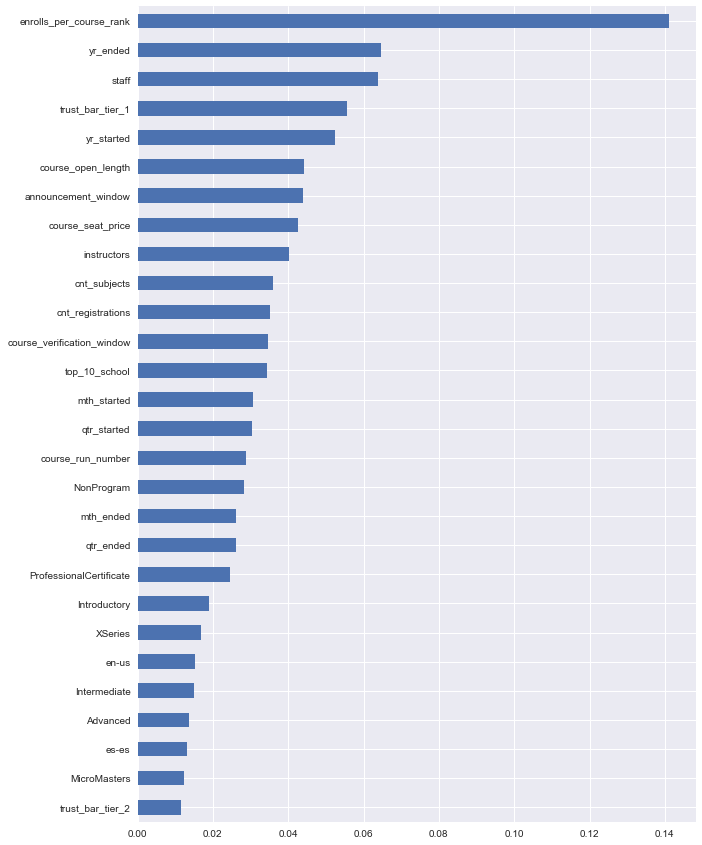

In [13]:
# Dispay the featured_cols (predictors of enrollment) in order of importance to the classifier
feature_importances = pd.Series(etc.feature_importances_, index=X.columns)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind="barh", figsize=(10,15));

In [14]:
# New Query for courses that have not yet ended which we can apply the trained model to
new_query = """
SELECT
	a.course_id,
	is_WL,
	course_start_date,
	course_end_date,
	course_verification_end_date,
    YEAR(course_start_date) AS yr_started,
    QUARTER(course_start_date) AS qtr_started,
    MONTH(course_start_date) AS mth_started,
    YEAR(course_end_date) AS yr_ended,
    QUARTER(course_end_date) AS qtr_ended,
    MONTH(course_end_date) AS mth_ended,
    DATEDIFF(day, course_announcement_date, course_start_date) AS announcement_window,
    DATEDIFF(day, course_start_date, course_end_date) AS course_open_length,
    DATEDIFF(day, course_start_date, course_verification_end_date) AS course_verification_window,
	course_seat_price,
	content_language,
	level_type,
	course_run_number,
	course_partner,
	CASE
		WHEN course_partner IN ('MITx', 'HarvardX', 'BerkeleyX', 'UTArlingtonX', 'UTAustinX', 'UTHealthSPHx', 'UTPermianBasin', 'UTSanAntonioX', 'UTMBx', 'UQx', 'DelftX') THEN 1 ELSE 0
	END AS trust_bar_tier_1,
	CASE
		WHEN course_partner IN ('BUx', 'SorbonneX', 'UBCx', 'USMx', 'GeorgetownX', 'AdelaideX') THEN 1 ELSE 0
	END AS trust_bar_tier_2,
	CASE
		WHEN course_partner IN ('RWTHx', 'ANUx') THEN 1 ELSE 0
	END AS trust_bar_tier_3,
	CASE
		WHEN course_partner IN ('MITx', 'HarvardX', 'BerkeleyX', 'CaltechX', 'OxfordX', 'ColumbiaX') THEN 1 ELSE 0
	END AS top_10_school,
	cnt_subjects,
	XSeries,
	ProfessionalCertificate,
	MicroMasters,
	NonProgram,
	enrollment_rank,
	bookings_rank,
	vtr_rank,
	enrolls_per_course_rank,
	bookings_per_course_rank,
	cnt_registrations,
	instructors,
    staff,
	sum_enrolls,
	sum_unenrolls,
	sum_verifications,
	sum_enrolls_vtr,
	cnt_paid_enrollments,
	b.sum_bookings
FROM
	business_intelligence.course_master a
LEFT JOIN
	business_intelligence.course_stats_summary b
ON
	a.course_id = b.course_id
LEFT JOIN
	ed_services.course_subjects c
ON
	a.course_id = c.course_id
LEFT JOIN
	ed_services.course_program d
ON
	a.course_id = d.course_id
LEFT JOIN
	ed_services.partner_rankings e
ON
	a.course_partner = e.org_id
LEFT JOIN
	ed_services.course_grouping f
ON
	a.course_id = f.course_id
LEFT JOIN
	business_intelligence.daily_stats g
ON
	a.course_start_date = g.date
LEFT JOIN
	ed_services.course_staff h
ON
	a.course_id = h.course_id
WHERE
	pacing_type = 'instructor_paced'
AND
	course_end_date > CURRENT_DATE()
AND
	course_verification_end_date IS NOT NULL
AND
	a.course_id NOT IN ('course-v1:MITx+ENx+2016_3T', 'course-v1:ASUx+AST111+3T2015')
;
"""

# Execute the Query from above
cur.execute(new_query)

new_query = """
SELECT
	a.course_id,
	is_WL,
	course_start_date,
	course_end_date,
	course_verification_end_date,
    YEAR(course_start_date) AS yr_started,
    QUARTER(course_start_date) AS qtr_started,
    MONTH(course_start_date) AS mth_started,
    YEAR(course_end_date) AS yr_ended,
    QUARTER(course_end_date) AS qtr_ended,
    MONTH(course_end_date) AS mth_ended,
    DATEDIFF(day, course_announcement_date, course_start_date) AS announcement_window,
    DATEDIFF(day, course_start_date, course_end_date) AS course_open_length,
    DATEDIFF(day, course_start_date, course_verification_end_date) AS course_verification_window,
	course_seat_price,
	content_language,
	level_type,
	course_run_number,
	course_partner,
	CASE
		WHEN course_partner IN ('MITx', 'HarvardX', 'BerkeleyX', 'UTArlingtonX', 'UTAustinX', 'UTHealthSPHx', 'UTPermianBasin', 'UTSanAntonioX', 'UTMBx', 'UQx', 'DelftX') THEN 1 ELSE 0
	END AS trust_bar_tier_1,
	CASE
		WHEN course_partner IN ('BUx', 'SorbonneX', 'UBCx', 'USMx', 'GeorgetownX', 'AdelaideX') THEN 1 ELSE 0
	END AS trust_bar_tier_2,
	CASE
		WHEN course_partner IN ('RWTHx', 'ANUx') THEN 1 ELSE 0
	END AS trust_bar_tier_3,
	CASE
		WHEN course_partner IN ('MITx', 'HarvardX', 'BerkeleyX', 'CaltechX', 'OxfordX', 'ColumbiaX') THEN 1 ELSE 0
	END AS top_10_school,
	cnt_subjects,
	XSeries,
	ProfessionalCertificate,
	MicroMasters,
	NonProgram,
	enrollment_rank,
	bookings_rank,
	vtr_rank,
	enrolls_per_course_rank,
	bookings_per_course_rank,
	cnt_registrations,
	instructors,
    staff,
	sum_enrolls,
	sum_unenrolls,
	sum_verifications,
	sum_enrolls_vtr,
	cnt_paid_enrollments,
	b.sum_bookings
FROM
	business_intelligence.course_master a
LEFT JOIN
	business_intelligence.course_stats_summary b
ON
	a.course_id = b.course_id
LEFT JOIN
	ed_services.course_subjects c
ON
	a.course_id = c.course_id
LEFT JOIN
	ed_services.course_program d
ON
	a.course_id = d.course_id
LEFT JOIN
	ed_services.partner_rankings e
ON
	a.course_partner = e.org_id
LEFT JOIN
	ed_services.course_grouping f
ON
	a.course_id = f.course_id
LEFT JOIN
	business_intelligence.daily_stats g
ON
	a.course_start_date = g.date
LEFT JOIN
	ed_services.course_staff h
ON
	a.course_id = h.course_id
WHERE
	pacing_type = 'instructor_paced'
AND
	course_end_date > CURRENT_DATE()
AND
	course_verification_end_date IS NOT NULL
AND
	a.course_id NOT IN ('course-v1:MITx+ENx+2016_3T', 'course-v1:ASUx+AST111+3T2015')
;
"""

# Execute the Query from above
cur.execute(new_query)

# Dump the query results into a Pandas DataFrame
new_course_data = pd.DataFrame(cur.fetchall())

In [15]:
# Create Dummy Columns
new_course_data = pd.concat([new_course_data, pd.get_dummies(new_course_data['level_type'])], axis=1)
new_course_data = pd.concat([new_course_data, pd.get_dummies(new_course_data['content_language'])], axis=1)

In [16]:
# Impute Missing Values
new_course_data['cnt_subjects'] = new_course_data['cnt_subjects'].fillna(new_course_data['cnt_subjects'].median())
new_course_data['cnt_registrations'] = new_course_data['cnt_registrations'].fillna(new_course_data['cnt_registrations'].median())
new_course_data['instructors'] = new_course_data['instructors'].fillna(new_course_data['instructors'].median())
new_course_data['staff'] = new_course_data['staff'].fillna(new_course_data['staff'].median())
new_course_data['announcement_window'] = new_course_data['announcement_window'].fillna(new_course_data['announcement_window'].median())

In [17]:
# Create Target Columnn to compare predictions to
new_course_data['High Performing Course'] = (new_course_data.sum_enrolls > course_data['sum_enrolls'].quantile(.66)).astype(int)

In [18]:
# Check the counts to make sure each column is the same
new_course_data.count()

course_id                       368
is_WL                           368
course_start_date               368
course_end_date                 368
course_verification_end_date    368
yr_started                      368
qtr_started                     368
mth_started                     368
yr_ended                        368
qtr_ended                       368
mth_ended                       368
announcement_window             368
course_open_length              368
course_verification_window      368
course_seat_price               368
content_language                363
level_type                      357
course_run_number               368
course_partner                  368
trust_bar_tier_1                368
trust_bar_tier_2                368
trust_bar_tier_3                368
top_10_school                   368
cnt_subjects                    368
XSeries                         368
ProfessionalCertificate         368
MicroMasters                    368
NonProgram                  

In [19]:
# Run the trained model using the new data set and add a column for predictions
X_new = new_course_data[feature_cols]

new_course_data['Predictions'] = etc.predict(X_new)

In [20]:
# Print out a confusion matrix to see how the predictions compare to the actuals
print metrics.confusion_matrix(new_course_data['High Performing Course'], new_course_data['Predictions'])
print metrics.classification_report(new_course_data['High Performing Course'], new_course_data['Predictions'])

[[301  42]
 [ 11  14]]
             precision    recall  f1-score   support

          0       0.96      0.88      0.92       343
          1       0.25      0.56      0.35        25

avg / total       0.92      0.86      0.88       368



In [21]:
# Display just the columns we're interested in to see if the model is accurate
display_cols = ['course_id', 'sum_enrolls', 'Predictions', 'High Performing Course']

new_course_data[display_cols]

,course_id,sum_enrolls,Predictions,High Performing Course
0,course-v1:ANUx+ANU-ASTRO2x+2T2017,23,0,0
1,course-v1:ASUx+ASM246+2174C,1943,0,0
2,course-v1:ASUx+ASM246+2177A,141,0,0
3,course-v1:ASUx+AST111x+2174C,1346,0,0
4,course-v1:ASUx+AST111x+2177B,168,0,0
5,course-v1:ASUx+CEE181x+2177A,856,0,0
6,course-v1:ASUx+CSE110x+2177C,1372,0,0
7,course-v1:ASUx+ECN211x+2177A,4264,0,0
8,course-v1:ASUx+ENG101x+2174C,18209,0,1
9,course-v1:ASUx+ENG101x+2177A,1462,0,0


In [22]:
# Print out results to csv
output_path = '/Users/ochang/Downloads/instructor_paced_high_performing_predictions.csv'
new_course_data.to_csv(output_path)